## Threat Detection Dash


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
import csv
import os



In [3]:
# Define or import the custom class EnsembleModel
class EnsembleModel:
    # Define the class methods and attributes as per your original model
    def predict(self, X):
        # Implement your prediction logic here
        return np.random.rand(X.shape[0], 1)  # Dummy implementation

def custom_load_model(file_path):
    """
    Custom function to load a joblib model handling the AttributeError.
    """
    try:
        return joblib.load(file_path)
    except AttributeError as e:
        # Handle the AttributeError by providing the custom class
        if 'EnsembleModel' in str(e):
            import sys
            sys.modules['__main__.EnsembleModel'] = EnsembleModel
            return joblib.load(file_path)
        else:
            raise


In [4]:
# Load the trained model using custom_load_model
model_path = '/content/drive/My Drive/MyModels/ensemble_model.pkl'
model = custom_load_model(model_path)

# Set up CSV logging
log_path = '/content/drive/My Drive/MyModels/real_time_log.csv'

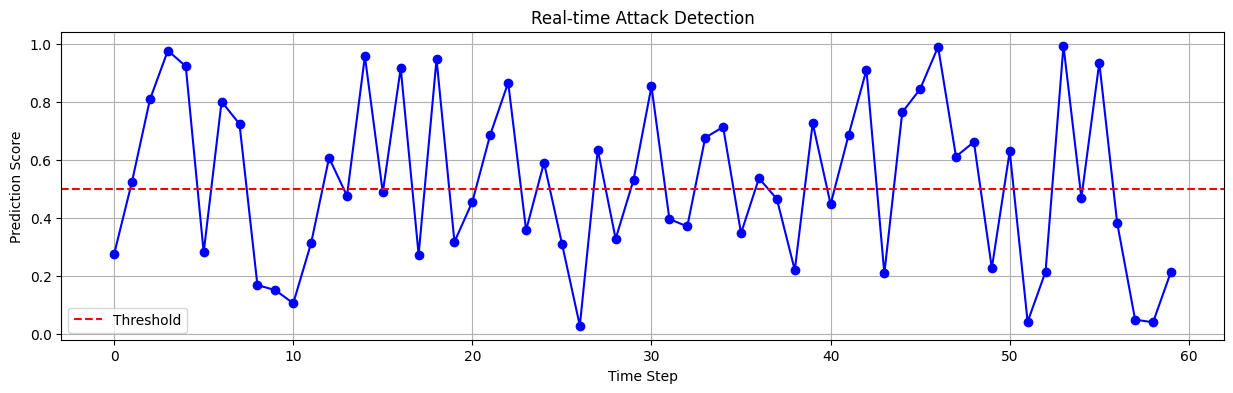

Real-time monitoring stopped.


In [5]:
# Function to display predictions as a line plot
def display_predictions(history, threshold=0.5):
    clear_output(wait=True)
    plt.figure(figsize=(15, 4))
    plt.plot(history, marker='o', linestyle='-', color='b')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Real-time Attack Detection')
    plt.xlabel('Time Step')
    plt.ylabel('Prediction Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to log data to CSV
def log_to_csv(data, log_path):
    df = pd.DataFrame([data])
    if not os.path.isfile(log_path):
        df.to_csv(log_path, index=False)
    else:
        df.to_csv(log_path, mode='a', header=False, index=False)

# Sample data to fit the scaler
# Here, we use synthetic data to fit the scaler for demonstration purposes
X_train_sample = np.random.rand(100, 10)  # Assuming 10 features
scaler = StandardScaler().fit(X_train_sample)

# Define label encoder and selected features
label_encoder = LabelEncoder()
selected_features = ['service', 'flag', 'src_bytes', 'dst_bytes', 'count',
                         'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate']

# Define preprocessing function
def preprocess_data(df, label_encoder, selected_features, scaler):
    # Encode categorical features
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = label_encoder.fit_transform(df[col])

    # Drop the 'num_outbound_cmds' column if it exists
    if 'num_outbound_cmds' in df.columns:
        df.drop(['num_outbound_cmds'], axis=1, inplace=True)

    # Select features
    df = df[selected_features]

    # Scale the features
    df_scaled = scaler.transform(df)

    return df_scaled

# Function to generate synthetic data
def generate_synthetic_data(num_samples, num_features):
    features = np.random.rand(num_samples, num_features)
    return features

# Function to stream real-time data
def stream_real_time_data(num_samples, num_features):
    while True:
        data = generate_synthetic_data(num_samples, num_features)
        yield data
        time.sleep(1)  # Simulate real-time delay

# Function to log data and predictions
def log_data(data, predictions, log_path):
    with open(log_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for i in range(len(data)):
            row = list(data[i]) + list(predictions[i])
            writer.writerow(row)

# Initialize CSV log file with headers
with open(log_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    headers = selected_features + ['prediction']
    writer.writerow(headers)

# Real-time monitoring and alert generation
try:
    prediction_history = []
    while True:
        for real_time_data in stream_real_time_data(1, 10):  # Assuming 10 features
            real_time_df = pd.DataFrame(real_time_data, columns=selected_features)
            preprocessed_data = preprocess_data(real_time_df, label_encoder, selected_features, scaler)

            # Make predictions
            predictions = model.predict(preprocessed_data)
            predicted_labels = (predictions > 0.5).astype(int)

            # Append predictions to history
            prediction_history.append(predictions.flatten()[0])

            # Log data and predictions
            log_data(real_time_data, predicted_labels, log_path)

            # Display predictions
            display_predictions(prediction_history)

            # Generate alert if an attack is detected
            if np.any(predicted_labels):
                print("Alert! Attack detected!")
except KeyboardInterrupt:
    print("Real-time monitoring stopped.")

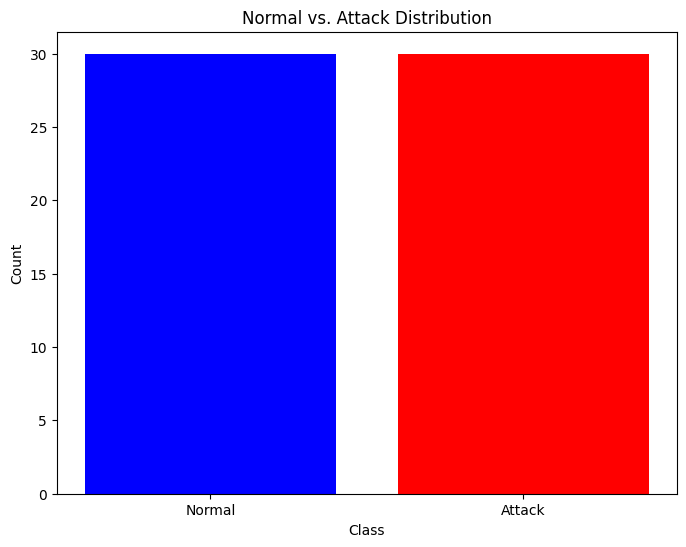

In [6]:
# Plotting the distribution of Normal vs. Attack events
def plot_attack_distribution(log_path):
    with open(log_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        data = list(reader)

    attack_count = sum(row[-1] == '1' for row in data)
    normal_count = sum(row[-1] == '0' for row in data)

    labels = ['Normal', 'Attack']
    values = [normal_count, attack_count]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Normal vs. Attack Distribution')
    plt.show()

# Call the function to plot the distribution
plot_attack_distribution(log_path)

## Attack Classification Dash

In [7]:
# Define path to the saved Decision Tree model
model_path_decision_tree = '/content/drive/My Drive/MyModels/decision_tree_model.joblib'

# Load the Decision Tree model
decision_tree_model = joblib.load(model_path_decision_tree)

log_path= '/content/drive/My Drive/MyModels/real_time_log_decision_tree.csv'

In [8]:
# Define features specific to Decision Tree model
decision_tree_features = [' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Min', 'Bwd IAT Total',
       ' Bwd IAT Std', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags',
       ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length',
       ' Bwd Packets/s', ' Min Packet Length', 'FIN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' Down/Up Ratio', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
       ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' min_seg_size_forward', 'Active Mean',
       ' Active Std', ' Active Max', ' Idle Std']

def preprocess_data(data, scaler):
    # Scale the features
    scaled_data = scaler.transform(data)
    return scaled_data


In [9]:
# Define self-healing actions
def restart_service(service_name):
    print(f"Restarting service: {service_name}")
    # Uncomment to execute on a real system
    # os.system(f'systemctl restart {service_name}')

def block_ip(ip_address):
    print(f"Blocking IP address: {ip_address}")
    # Uncomment to execute on a real system
    # os.system(f'iptables -A INPUT -s {ip_address} -j DROP')

def alert_admin(message):
    print(f"Alerting admin: {message}")
    # Implement email or SMS notification

# Define the action for each attack type (example actions, replace with actual actions)
attack_actions = {
    'DDoS': lambda: restart_service('apache2'),
    'DoS Hulk': lambda: block_ip('192.168.1.1'),
    'PortScan': lambda: alert_admin('Port scanning detected'),
    'FTP-Patator': lambda: block_ip('192.168.1.2'),
    'DoS slowloris': lambda: restart_service('nginx'),
    'DoS Slowhttptest': lambda: restart_service('nginx'),
    'Bot': lambda: alert_admin('Bot activity detected'),
    'SSH-Patator': lambda: block_ip('192.168.1.3'),
    'Web Attack – Brute Force': lambda: alert_admin('Brute force attack detected'),
    'Web Attack – XSS': lambda: alert_admin('XSS attack detected'),
    'Infiltration': lambda: alert_admin('Infiltration detected'),
    'Web Attack – Sql Injection': lambda: alert_admin('SQL injection detected')
}

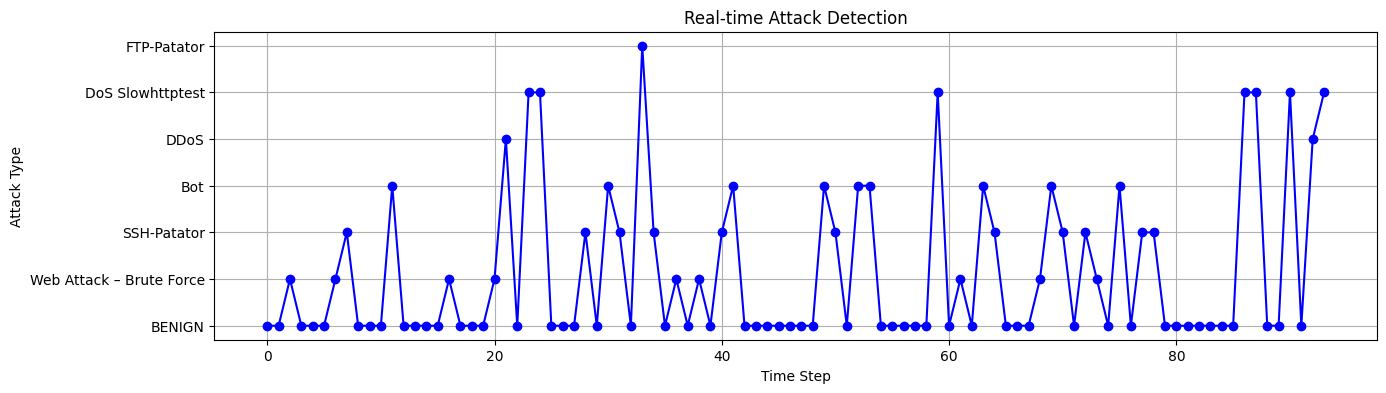

In [10]:
# Function to generate synthetic data (for demonstration purposes)
def generate_synthetic_data(num_samples, num_features):
    features = np.random.rand(num_samples, num_features)
    return features

# Function to stream real-time data
def stream_real_time_data(num_samples, num_features):
    while True:
        data = generate_synthetic_data(num_samples, num_features)
        yield data
        time.sleep(1)  # Simulate real-time delay

# Assuming 'scaler' is defined globally or within the setup code
scaler = StandardScaler()

# Initialize and fit the StandardScaler
X_train_sample = np.random.rand(100, len(decision_tree_features))  # Assuming 100 samples for fitting
scaler = StandardScaler().fit(X_train_sample)


# Mapping of encoded attack types to their corresponding names
attack_names = {
    0: 'BENIGN',
    1: 'DoS Hulk',
    2: 'DDoS',
    3: 'PortScan',
    4: 'FTP-Patator',
    5: 'DoS slowloris',
    6: 'DoS Slowhttptest',
    7: 'SSH-Patator',
    8: 'DoS GoldenEye',
    9: 'Web Attack – Brute Force',
    10: 'Bot',
    11: 'Web Attack – XSS',
    12: 'Web Attack – Sql Injection',
    13: 'Infiltration'
}

# Function to preprocess data
def preprocess_data(data, scaler):
    # Scale the features
    data_scaled = scaler.transform(data)
    return data_scaled

# Function to perform classification and self-healing actions
def perform_classification_and_self_healing(data, scaler):
    # Preprocess data using 'scaler' and other necessary preprocessing steps
    preprocessed_data = preprocess_data(data, scaler)

    # Perform classification using decision tree model
    attack_type_encoded = decision_tree_model.predict(preprocessed_data)[0]
    attack_type = attack_names.get(attack_type_encoded, 'Unknown')  # Get attack name based on encoded label

    # Perform self-healing actions based on predicted attack type
    action_taken = perform_self_healing(attack_type, attack_type_encoded)  # Call the self-healing function

    return attack_type, action_taken

# Define self-healing actions
def perform_self_healing(attack_type, attack_type_encoded):
    # Define the action for each attack type (example actions, replace with actual actions)
    attack_actions = {
        'DDoS': lambda: restart_service('apache2', attack_type_encoded),
        'DoS Hulk': lambda: block_ip('192.168.1.1', attack_type_encoded),
        'PortScan': lambda: alert_admin('Port scanning detected', attack_type_encoded),
        'FTP-Patator': lambda: block_ip('192.168.1.2', attack_type_encoded),
        'DoS slowloris': lambda: restart_service('nginx', attack_type_encoded),
        'DoS Slowhttptest': lambda: restart_service('nginx', attack_type_encoded),
        'Bot': lambda: alert_admin('Bot activity detected', attack_type_encoded),
        'SSH-Patator': lambda: block_ip('192.168.1.3', attack_type_encoded),
        'Web Attack – Brute Force': lambda: alert_admin('Brute force attack detected', attack_type_encoded),
        'Web Attack – XSS': lambda: alert_admin('XSS attack detected', attack_type_encoded),
        'Infiltration': lambda: alert_admin('Infiltration detected', attack_type_encoded),
        'Web Attack – Sql Injection': lambda: alert_admin('SQL injection detected', attack_type_encoded),
        'BENIGN': lambda: log_action('No action needed for BENIGN', attack_type_encoded),
        'DoS GoldenEye': lambda: log_action('No action needed for DoS GoldenEye', attack_type_encoded),
        'Unknown': lambda: log_action('Unknown attack type', attack_type_encoded)
    }

    # Execute the corresponding action based on the attack type
    if attack_type in attack_actions:
        action_name = attack_actions[attack_type]()
        return action_name
    else:
        return f"No action defined for {attack_type}"

def restart_service(service_name, attack_type_encoded):
    print(f"Restarting service: {service_name} for attack type {attack_type_encoded}")
    # Uncomment to execute on a real system
    # os.system(f'systemctl restart {service_name}')
    return f"Restarted service: {service_name} for attack type {attack_type_encoded}"  # Return action taken

def block_ip(ip_address, attack_type_encoded):
    print(f"Blocking IP address: {ip_address} for attack type {attack_type_encoded}")
    # Uncomment to execute on a real system
    # os.system(f'iptables -A INPUT -s {ip_address} -j DROP')
    return f"Blocked IP address: {ip_address} for attack type {attack_type_encoded}"  # Return action taken

def alert_admin(message, attack_type_encoded):
    print(f"Alerting admin: {message} for attack type {attack_type_encoded}")
    # Implement email or SMS notification
    return f"Alerted admin: {message} for attack type {attack_type_encoded}"  # Return action taken

def log_action(message, attack_type_encoded):
    print(message)
    return message

# Function to display predictions as a line plot
def display_predictions(history):
    clear_output(wait=True)
    plt.figure(figsize=(15, 4))
    plt.plot(history, marker='o', linestyle='-', color='b')
    plt.title('Real-time Attack Detection')
    plt.xlabel('Time Step')
    plt.ylabel('Attack Type')
    plt.grid(True)
    plt.show()

# Function to log data to CSV
def log_data(data, prediction, action_taken, log_path):
    with open(log_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(list(data[0]) + [prediction, action_taken])  # Assuming data is a single row array

# Initialize CSV log file with headers
with open(log_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    headers = decision_tree_features + ['prediction', 'self_healing_action']
    writer.writerow(headers)

# Real-time monitoring and alert generation
monitoring_running = True
prediction_history = []
action_history = []

try:
    for real_time_data in stream_real_time_data(1, len(decision_tree_features)):
        # Perform classification and self-healing actions
        attack_type, action_taken = perform_classification_and_self_healing(real_time_data, scaler)

        # Log data
        log_data(real_time_data, attack_type, action_taken, log_path)

        # Display predictions
        prediction_history.append(attack_type)
        display_predictions(prediction_history)

        # Print the self-healing action taken in real-time
        print(f"Real-time Self-healing action: {action_taken}")
        action_history.append(action_taken)

except KeyboardInterrupt:
    monitoring_running = False
    print("Real-time monitoring stopped.")

    # Display the last plot with the actions performed
    if prediction_history:
        display_predictions(prediction_history)

    # Log actions performed with timestamps
    with open(log_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Real-time monitoring stopped'])
        for i, action in enumerate(action_history, 1):
            writer.writerow([f"{i}. {action}"])

# Keep the last plot visible after loop stops
if prediction_history:
    display_predictions(prediction_history)



<ipython-input-11-801096181c63>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attack_names.values(), y=counts, palette='Set2')


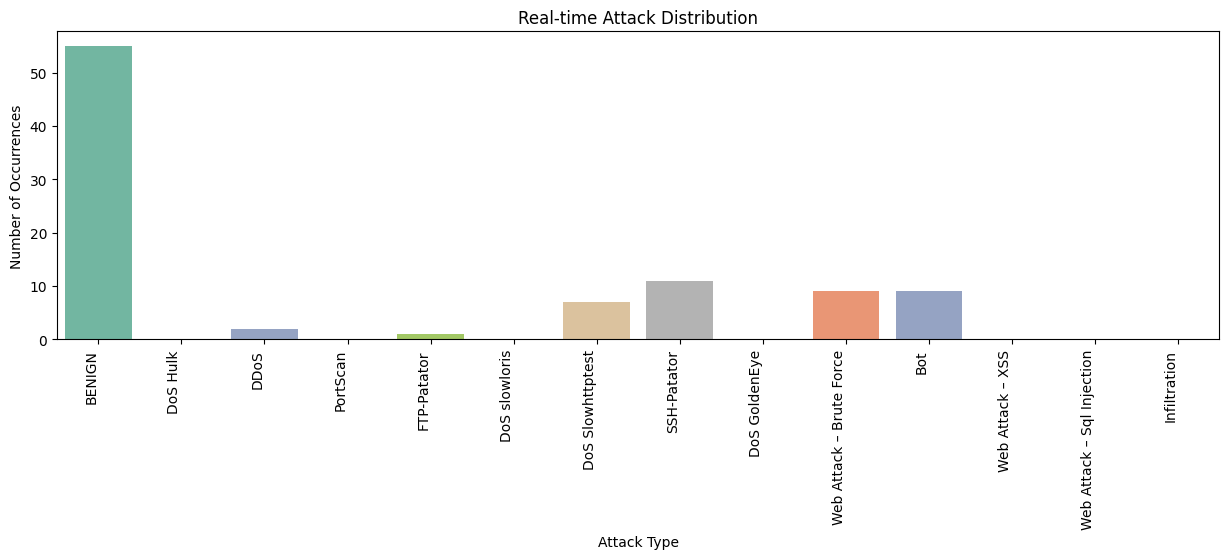

In [11]:
# Prepare data for the bar plot
attack_types = prediction_history
counts = [attack_types.count(attack) for attack in attack_names.values()]

# Create the bar plot with color and labels
plt.figure(figsize=(15, 4))
sns.barplot(x=attack_names.values(), y=counts, palette='Set2')
plt.title('Real-time Attack Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90, ha='right')
plt.show()


<ipython-input-12-69389891f806>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_actions, y=counts, palette='viridis')


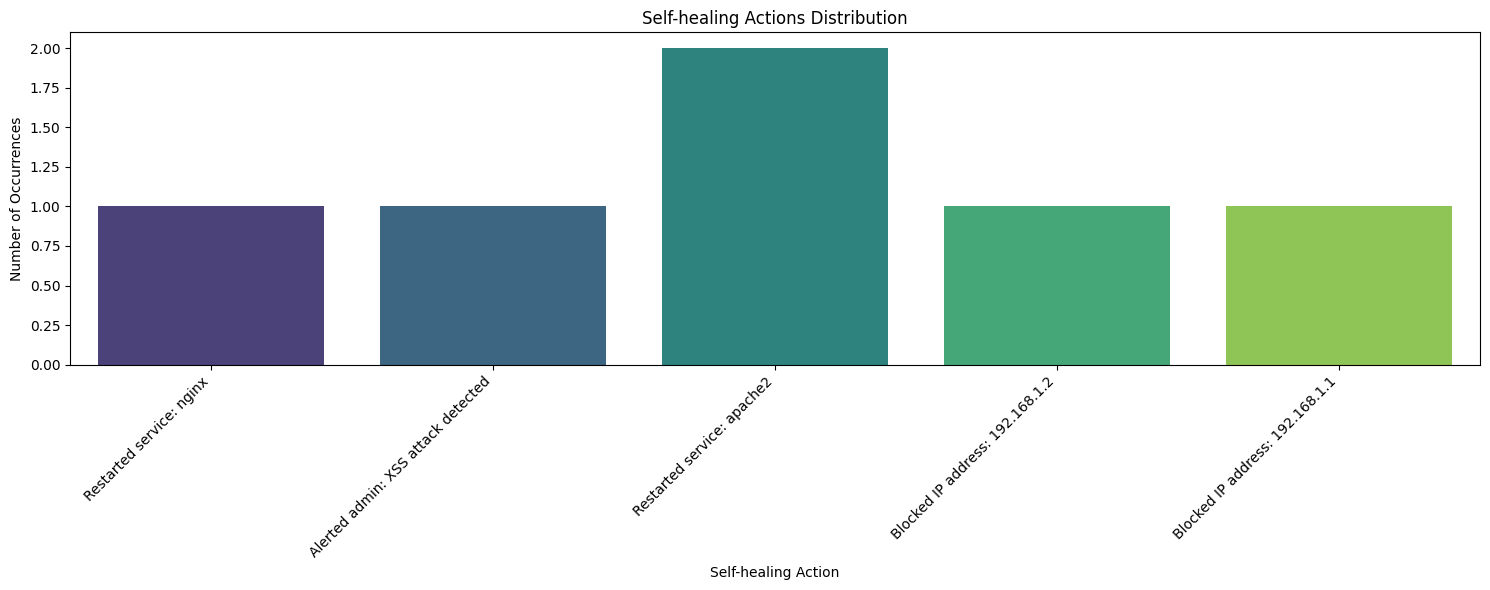

In [12]:
# Example action history (replace with your actual action_history)
action_history = ['Restarted service: apache2', 'Blocked IP address: 192.168.1.1', 'Restarted service: nginx',
                  'Alerted admin: XSS attack detected', 'Blocked IP address: 192.168.1.2', 'Restarted service: apache2']

# Prepare data for the bar plot
unique_actions = list(set(action_history))
counts = [action_history.count(action) for action in unique_actions]

# Create the bar plot with color and labels
plt.figure(figsize=(15, 6))
sns.barplot(x=unique_actions, y=counts, palette='viridis')
plt.title('Self-healing Actions Distribution')
plt.xlabel('Self-healing Action')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

